# Employee Turn Over - Model training

training process v5
xgboost

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import joblib
import sys

sys.path.append('../../src/')

from modeleval import binary_eval
warnings.filterwarnings("ignore")


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.metrics import average_precision_score, make_scorer
import shap
from bayes_opt import BayesianOptimization

from xgboost import XGBClassifier

In [3]:
# !pip install shap
# !pip install bayesian-optimization 
# !pip install xgboost

In [5]:
PATH_DATA='../../data/raw/'
PATH_DATA_INTERIM='../../data/iter2/interim/'
PATH_MODEL = '../../model/iter2/'
VERS = '5'

model_file = PATH_MODEL+'model_'+VERS+'.pkl'

## Get Data

In [7]:
df1 = pd.read_csv(PATH_DATA_INTERIM+'iter2_interim_cln.csv')

In [8]:
## we use 1 as turn over
df1['target'] = (df1.stillExists==False).astype(int)
col_used = list(set(df1.columns)-set(['unique_employee_ids','stillExists','companyAlias','is_train','target']))

col_used.sort() ## --> remember to sort

In [9]:
Xtrain = df1[df1.is_train == 1][col_used]
Ytrain = df1[df1.is_train == 1]['target']

Xtest = df1[df1.is_train == 0][col_used]
Ytest = df1[df1.is_train == 0]['target']

In [10]:
Xtrain.shape, Xtest.shape

((3338, 52), (1431, 52))

In [11]:
1-Ytrain.mean(), 1-Ytest.mean()

(0.768424206111444, 0.7721872816212438)

In [12]:
0.76/(1-0.76)

3.166666666666667

## Transformation

if needed

In [13]:
SS = StandardScaler()
SS.fit(Xtrain)

joblib.dump(SS, PATH_MODEL+'scaler_'+VERS+'.pkl')

['../../model/iter2/scaler_5.pkl']

In [14]:
Xtrain_ss = pd.DataFrame(SS.transform(Xtrain), columns = col_used)
Xtest_ss = pd.DataFrame(SS.transform(Xtest), columns = col_used)

## Model

In [15]:
spw = 3

In [16]:
def targ_func(y_true, y_pred):
    diff = average_precision_score(y_true,y_pred)
    return diff

In [17]:
targ = make_scorer(targ_func, greater_is_better=True)
def loss_target(max_depth,learning_rate,n_estimators,
                 gamma, reg_alpha,reg_lambda,X=Xtrain_ss,y=Ytrain, scale = spw):

    md= int(max_depth)
    lr= max(learning_rate,0)
    ne= int(n_estimators)
    gamma= max(gamma, 0) # 0
    ra= max(reg_alpha, 0) # 0
    rl= max(reg_lambda, 0) # 1
    see= 123

    xgB=XGBClassifier(objective='binary:logistic',max_depth=md,learning_rate=lr,
                     n_estimators=ne,gamma=gamma,reg_alpha=ra,reg_lambda=rl,seed=see,scale_pos_weight=scale,
                      n_jobs=3)
    cv_results = cross_validate(xgB, X, y, cv=5, scoring=targ, n_jobs= 3)
    return cv_results['test_score'].mean()


In [18]:
xgbBO = BayesianOptimization(loss_target,{'max_depth': (8,15),'learning_rate': (0.02, 0.1),
                                            'n_estimators': (40,70),'gamma': (0.75, 2),'reg_alpha': (1.5, 3),
                                            'reg_lambda': (1.5, 2.5)})

xgbBO.maximize(init_points=25, n_iter=10)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------
| 1         | 0.4663    | 0.828     | 0.07971   | 13.26     | 68.83     | 1.579     | 1.719     |
| 2         | 0.4755    | 1.414     | 0.0613    | 9.376     | 63.91     | 2.491     | 2.198     |
| 3         | 0.4723    | 1.097     | 0.04657   | 14.71     | 65.96     | 1.8       | 2.158     |
| 4         | 0.4773    | 1.159     | 0.04722   | 8.43      | 61.39     | 2.251     | 2.21      |
| 5         | 0.4755    | 0.9972    | 0.04339   | 14.49     | 62.85     | 2.691     | 1.824     |
| 6         | 0.4722    | 0.8692    | 0.0703    | 11.64     | 59.39     | 1.914     | 2.483     |
| 7         | 0.4701    | 0.9742    | 0.09749   | 8.608     | 63.85     | 2.858     | 1.644     |
| 8         | 0.4735    | 1.056     | 0.08477   | 14.53     | 65.04     | 2.861     | 2.211     |
| 9         | 0.467 

In [19]:
used_param = xgbBO.max['params']
used_param

{'gamma': 1.401868533026954,
 'learning_rate': 0.045023848908776073,
 'max_depth': 9.50676007536958,
 'n_estimators': 59.067613689276826,
 'reg_alpha': 2.221355771789343,
 'reg_lambda': 2.155905943616395}

In [20]:
used_param['n_jobs'] = 3
used_param['objective']='binary:logistic'
used_param['scale_pos_weight']=spw
for c in ['max_depth','n_estimators']:
    used_param[c] = int(used_param[c])

In [21]:
tModel = XGBClassifier(**used_param)
tModel.fit(Xtrain_ss,Ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.401868533026954, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.045023848908776073, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=59, n_jobs=3, num_parallel_tree=None, predictor=None,
              random_state=None, ...)

In [22]:
joblib.dump(tModel, model_file)
tModel_load = joblib.load(model_file)

## Evaluations

In [23]:
%matplotlib inline

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2565
           1       0.86      0.97      0.91       773

    accuracy                           0.96      3338
   macro avg       0.93      0.96      0.94      3338
weighted avg       0.96      0.96      0.96      3338

aucpr :  0.8394
aucroc :  0.9591


(0.8394, 0.9591)

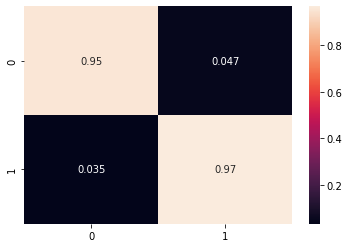

In [24]:
binary_eval(Ytrain, model=tModel_load, predictor=Xtrain_ss)

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1105
           1       0.78      0.85      0.81       326

    accuracy                           0.91      1431
   macro avg       0.87      0.89      0.88      1431
weighted avg       0.91      0.91      0.91      1431

aucpr :  0.6957
aucroc :  0.8902


(0.6957, 0.8902)

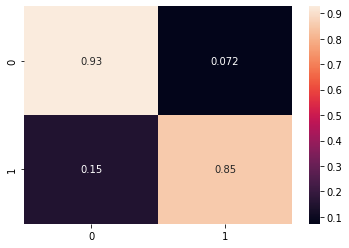

In [25]:
binary_eval(Ytest, model=tModel_load, predictor=Xtest_ss)

## Feature Importance

In [26]:
explainer = shap.TreeExplainer(tModel_load)
# masker = shap.maskers.Independent(data=Xtest_ss)
# explainer = shap.Explainer(
#     tModel_load, masker=masker, feature_names=Xtest_ss.columns, algorithm="linear"
# )
shap_values = explainer.shap_values(Xtrain_ss)

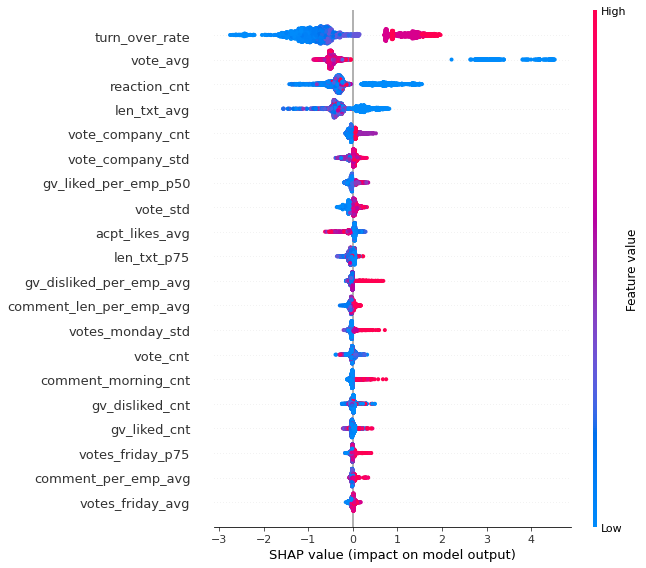

In [27]:
shap.summary_plot(shap_values, features=Xtrain_ss, feature_names=Xtest_ss.columns)

In [28]:
# shap.summary_plot(shap_values, Xtest_ss, plot_type="bar")

In [29]:
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values, Xtest_ss)

In [30]:
# shap.dependence_plot('vote_avg', shap_values, Xtest_ss)

In [31]:
vals = np.abs(shap_values).mean(0)
feature_names = Xtest_ss.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)

In [32]:
feature_importance.to_csv(PATH_MODEL+'feat_importance_'+VERS+'.csv', index = False)

In [33]:
feature_importance.head()

,col_name,feature_importance_vals
31,turn_over_rate,0.988755
32,vote_avg,0.729445
30,reaction_cnt,0.510195
25,len_txt_avg,0.354351
35,vote_company_cnt,0.090374
